In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
ds = pd.read_csv('healthcare-dataset-stroke-data.csv', delimiter=',')

In [4]:
ds.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [5]:
ds.drop(['id'], axis=1, inplace=True)

In [6]:
ds.stroke[ds.gender == 'Other']

3116    0
Name: stroke, dtype: int64

In [7]:
ds.drop([3116], inplace=True)

In [8]:
ds.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [9]:
columns_numeric = ['age', 'avg_glucose_level', 'bmi']
columns_categorical = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
                       'work_type', 'Residence_type', 'smoking_status']
columns_dummis = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
columns_target = ['stroke']

In [10]:
def replace_nan(data, to_replace, replacement_data):
    
    data_def = data.copy(deep=True)
    
    index_zero = list(data_def[to_replace][data_def[replacement_data] == 0].index)
    index_one = list(data_def[to_replace][data_def[replacement_data] == 1].index)
    
    for i in range(2):
        minimum = data_def[to_replace][data_def[replacement_data] == i].quantile(0.25)
        maximum = data_def[to_replace][data_def[replacement_data] == i].quantile(0.75)
        
        minimum -= (maximum - minimum) * 0.5
        maximum += (maximum - minimum) * 0.5
    
        count = data_def[to_replace][data_def[replacement_data] == i].isnull().sum()
        
        data_for_nan = np.random.choice(range(int(minimum), int(maximum)), count)
    
        if i == 0:
            index_null = data_def[to_replace][index_zero][data_def[to_replace].isnull()].index
        else:
            index_null = data_def[to_replace][index_one][data_def[to_replace].isnull()].index
        
        data_def[to_replace][index_null] = data_for_nan
        
    return data_def

In [11]:
ds = replace_nan(ds, 'bmi', 'stroke')

In [12]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   Residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 639.0+ KB


In [13]:
ds = pd.get_dummies(ds, columns=columns_dummis, prefix_sep='_', drop_first=True)

In [14]:
ds.head(3)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,1,1,0,1,0,0,1,1,0,0
1,61.0,0,0,202.21,24.0,1,0,1,0,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.5,1,1,1,0,1,0,0,0,0,1,0


In [15]:
from sklearn.model_selection import train_test_split

In [16]:
ds_train, ds_test = train_test_split(ds, test_size=0.3, random_state=42, stratify=ds.stroke)

In [17]:
ds_train.stroke.value_counts(normalize=True), ds_test.stroke.value_counts(normalize=True)

(0    0.951342
 1    0.048658
 Name: stroke, dtype: float64,
 0    0.951076
 1    0.048924
 Name: stroke, dtype: float64)

In [18]:
ds_train.shape[0] + ds_test.shape[0], ds.shape

(5109, (5109, 16))

In [19]:
add_rows = int(ds_train.stroke.value_counts()[0] * .8 - ds_train.stroke.value_counts()[1])
add_rows

2547

In [20]:
int(add_rows / ds_train.stroke.value_counts()[1]), ds_train.stroke.value_counts()

(14,
 0    3402
 1     174
 Name: stroke, dtype: int64)

In [21]:
index_train_one = ds_train.stroke[ds_train.stroke == 1].index
ds_train_one = ds_train.loc[index_train_one]

In [22]:
for i in range(14):
    ds_train = ds_train.append(ds_train_one)
    #y_train = pd.concat([y_train, y_train[y_train == 1]])

In [23]:
ds_train.stroke.value_counts(normalize=True)

0    0.565868
1    0.434132
Name: stroke, dtype: float64

In [24]:
from sklearn.utils import shuffle

In [25]:
ds_train = shuffle(ds_train)

### --------------- metrics ------------------------

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix

In [27]:
def print_metrics(actual, predict):
    print('Accuracy: {:.3f}'.format(accuracy_score(actual, predict)))
    print('Precision: {:.3f}'.format(precision_score(actual, predict)))
    print('Recall: {:.3f}'.format(recall_score(actual, predict)))
    print('F1 score: {:.3f}'.format(f1_score(actual, predict)))

In [28]:
def plot_roc_auc(actual, predict):
    
    fpr, tpr, threshold = roc_curve(actual, predict)
    plt.plot(fpr, tpr, color='b')
    #plt.plot()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0.0, 1.0], [0.0, 1.0], color='r')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC = {:.3f}'.format(roc_auc_score(actual, predict)))

### -------------- Voting ------------------------

In [29]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [30]:
model_tree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=6, min_samples_leaf=1, 
                                    max_features=4, random_state=160)
model_RF = RandomForestClassifier(n_estimators=1000, criterion='entropy', max_leaf_nodes=3, 
                                  max_features='auto', bootstrap=False, random_state=159, 
                                  n_jobs=-1)
model_svc = SVC(kernel='rbf', C=0.4, gamma=0.01, probability=True, random_state=33)
model_LR = LogisticRegression(penalty='l2', C=1.0, random_state=33, n_jobs=-1)

model_voting = VotingClassifier(estimators=[('tree', model_tree), ('RF', model_RF), ('SVC', model_svc), 
                                            ('LR', model_LR)], 
                                voting='hard', weights=[1, 1, 1, 1], n_jobs=-1)

In [31]:
%%time
model_tree.fit(ds_train.drop(['stroke'], axis=1), ds_train.stroke)
model_RF.fit(ds_train.drop(['stroke'], axis=1), ds_train.stroke)
model_svc.fit(ds_train.drop(['stroke'], axis=1), ds_train.stroke)
model_LR.fit(ds_train.drop(['stroke'], axis=1), ds_train.stroke)
model_voting.fit(ds_train.drop(['stroke'], axis=1), ds_train.stroke)

CPU times: user 9.72 s, sys: 444 ms, total: 10.2 s
Wall time: 16.6 s


VotingClassifier(estimators=[('tree',
                              DecisionTreeClassifier(max_depth=6,
                                                     max_features=4,
                                                     random_state=160)),
                             ('RF',
                              RandomForestClassifier(bootstrap=False,
                                                     criterion='entropy',
                                                     max_leaf_nodes=3,
                                                     n_estimators=1000,
                                                     n_jobs=-1,
                                                     random_state=159)),
                             ('SVC',
                              SVC(C=0.4, gamma=0.01, probability=True,
                                  random_state=33)),
                             ('LR',
                              LogisticRegression(n_jobs=-1, random_state=33))],
                 

In [32]:
for model, label in zip([model_tree, model_RF, model_svc, model_LR, model_voting], 
                        ['tree', 'RF', 'SVC', 'LR', 'Voting']):
    print('-'*5, label, '-'*5)
    print_metrics(ds_test.stroke, model.predict(ds_test.drop(['stroke'], axis=1)))
    print()

----- tree -----
Accuracy: 0.778
Precision: 0.122
Recall: 0.573
F1 score: 0.201

----- RF -----
Accuracy: 0.731
Precision: 0.126
Recall: 0.760
F1 score: 0.217

----- SVC -----
Accuracy: 0.785
Precision: 0.135
Recall: 0.627
F1 score: 0.222

----- LR -----
Accuracy: 0.771
Precision: 0.148
Recall: 0.773
F1 score: 0.248

----- Voting -----
Accuracy: 0.806
Precision: 0.155
Recall: 0.667
F1 score: 0.251



In [33]:
model_voting = VotingClassifier(estimators=[('tree', model_tree), ('RF', model_RF), ('SVC', model_svc), 
                                            ('LR', model_LR)], 
                                voting='hard', weights=[1, 1, 1, 1], n_jobs=-1)

In [34]:
model_voting.fit(ds_train.drop(['stroke'], axis=1), ds_train.stroke)

VotingClassifier(estimators=[('tree',
                              DecisionTreeClassifier(max_depth=6,
                                                     max_features=4,
                                                     random_state=160)),
                             ('RF',
                              RandomForestClassifier(bootstrap=False,
                                                     criterion='entropy',
                                                     max_leaf_nodes=3,
                                                     n_estimators=1000,
                                                     n_jobs=-1,
                                                     random_state=159)),
                             ('SVC',
                              SVC(C=0.4, gamma=0.01, probability=True,
                                  random_state=33)),
                             ('LR',
                              LogisticRegression(n_jobs=-1, random_state=33))],
                 

In [35]:
y_pred = model_voting.predict(ds_test.drop(['stroke'], axis=1))

In [36]:
print_metrics(ds_test.stroke, y_pred)

Accuracy: 0.806
Precision: 0.155
Recall: 0.667
F1 score: 0.251


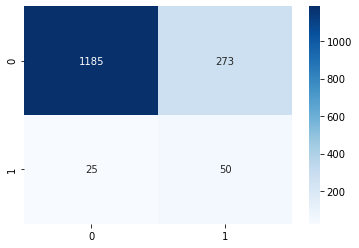

In [37]:
sns.heatmap(confusion_matrix(ds_test.stroke, y_pred), cmap='Blues', annot=True, fmt='');

In [42]:
model_LR.__class__.__name__

'LogisticRegression'

In [44]:
model_voting = VotingClassifier(estimators=[('tree', model_tree), ('RF', model_RF), ('SVC', model_svc), 
                                            ('LR', model_LR)], 
                                voting='soft', weights=[1, 1, 1, 1], n_jobs=-1)

In [47]:
model_voting.fit(ds_train.drop(['stroke'], axis=1), ds_train.stroke)

VotingClassifier(estimators=[('tree',
                              DecisionTreeClassifier(max_depth=6,
                                                     max_features=4,
                                                     random_state=160)),
                             ('RF',
                              RandomForestClassifier(bootstrap=False,
                                                     criterion='entropy',
                                                     max_leaf_nodes=3,
                                                     n_estimators=1000,
                                                     n_jobs=-1,
                                                     random_state=159)),
                             ('SVC',
                              SVC(C=0.4, gamma=0.01, probability=True,
                                  random_state=33)),
                             ('LR',
                              LogisticRegression(n_jobs=-1, random_state=33))],
                 

In [48]:
y_pred_prob = model_voting.predict_proba(ds_test.drop(['stroke'], axis=1))

#### finding the optimal threshold

In [49]:
f1_sc = []
threshold = []
rec_sc = []
prec_sc = []

for i in np.linspace(0.0, 1.0, 1000):
    recall_sc = recall_score(ds_test.stroke, y_pred_prob[:, 1] > i)
    precision_sc = precision_score(ds_test.stroke, y_pred_prob[:, 1] > i)
    f_one = f1_score(ds_test.stroke, y_pred_prob[:, 1] > i)
    f1_sc.append(f_one)
    threshold.append(i)
    rec_sc.append(recall_sc)
    prec_sc.append(precision_sc)

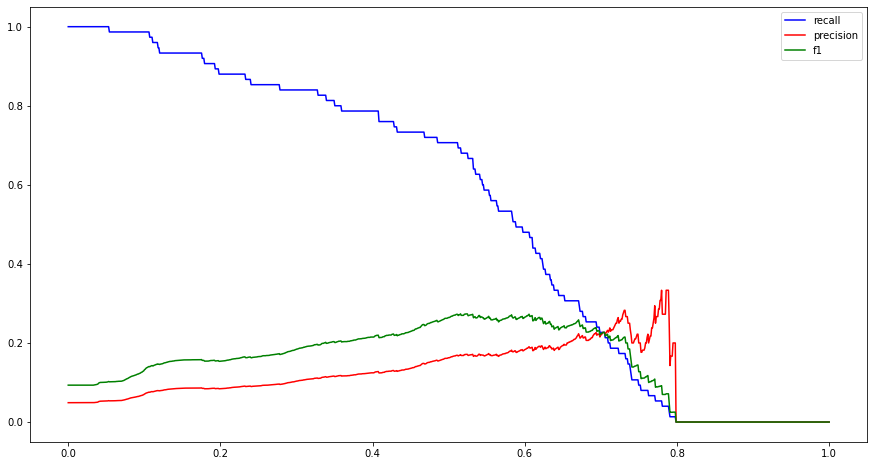

In [50]:
plt.figure(figsize=(15, 8))
plt.plot(np.linspace(0.0, 1.0, 1000), rec_sc, color='b', label='recall')
plt.plot(np.linspace(0.0, 1.0, 1000), prec_sc, color='r', label='precision')
plt.plot(np.linspace(0.0, 1.0, 1000), f1_sc, color='green', label='f1')
plt.legend(loc='upper right')
plt.show()

In [51]:
ds_sc = pd.DataFrame({'threshold': threshold,'f1': f1_sc, 'recall': rec_sc, 'precision': prec_sc}, range(len(f1_sc)))

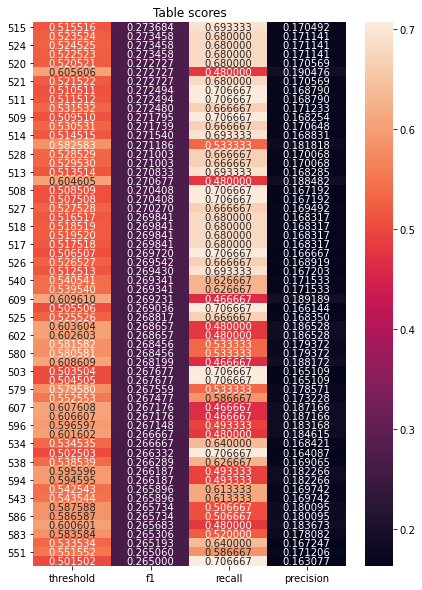

In [57]:
plt.figure(figsize=(7, 10))
sns.heatmap(ds_sc.sort_values(by='f1',ascending=False)[:60], annot=True, fmt='.6f')
plt.title('Table scores');

In [53]:
# optimal threshold
threshold[515]

0.5155155155155156

In [54]:
conf_matrix = confusion_matrix(ds_test.stroke, y_pred_prob[:, 1] > 0.5155155155155156)

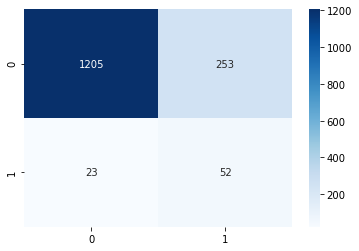

In [55]:
sns.heatmap(conf_matrix, cmap='Blues', annot=True, fmt='');

In [56]:
print_metrics(ds_test.stroke, y_pred_prob[:, 1] > 0.5155155155155156)

Accuracy: 0.820
Precision: 0.170
Recall: 0.693
F1 score: 0.274
